# Presentation and discussion of several options for text preprocessing
**input**: a raw document collection $D$

**output**: the vector space model of $D$ as a matrix $M \in \mathbb{R}^{\mid D \mid \times f}$ 

**steps**:
- document tokenization
- tokens normalization
- weighting

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

## YELP review
[YELP dataset](https://www.yelp.com/dataset)

In [2]:
from sqlalchemy import create_engine
import json

In [3]:
with open('/Users/flint/Data/postgresql/conf.json', 'r') as conf_file:
    conf = json.load(conf_file)

In [4]:
engine = create_engine('postgresql+psycopg2://postgres:{}@localhost/nlp'.format(conf['psw']))

In [6]:
sql = "SELECT * FROM yelp.textclip T JOIN yelp.review R ON T.id = R.clip LIMIT 5000"
reviews = pd.read_sql(sql, engine)

In [7]:
docs = list(reviews.content.values)

In [8]:
print(docs[10])

The poutines are good, the strength of the place is its variety and ambiance. I wouldn't say its the best place for poutine however.


## Tokenization
Explore different options for tokenize the text and show their impact on the number $f$ of different features in $M$.

In [9]:
from nltk import word_tokenize
import nltk
from indexing import InMemoryCountIndex

In [10]:
def char_tokenizer(doc):
    return list(doc)

def bigram_char_tokenizer(doc):
    return ["{}{}".format(a, b) for a, b in nltk.ngrams(list(doc), 2)]

def bigram_tokenizer(doc):
    return ["{} {}".format(a, b) for a, b in nltk.ngrams(word_tokenize(doc), n=2)]

def trigram_tokenizer(doc):
    return ["{} {} {}".format(a, b, c) for a, b, c in nltk.ngrams(word_tokenize(doc), n=3)]

In [11]:
tokenizers = {
    'CHAR': char_tokenizer, '2GCHAR': bigram_char_tokenizer, 'WORD': word_tokenize, 
    '2GRAM': bigram_tokenizer, '3GRAM': trigram_tokenizer
}

In [12]:
example = docs[0] 
for label, tokenizer in tokenizers.items():
    tokens = tokenizer(example)
    print(label, "\t=>({}/{})".format(len(set(tokens)), len(tokens)), "|".join(tokens[:10]), '...')

CHAR 	=>(33/322) R|e|d|,| |w|h|i|t|e ...
2GCHAR 	=>(153/321) Re|ed|d,|, | w|wh|hi|it|te|e  ...
WORD 	=>(53/72) Red|,|white|and|bleu|salad|was|super|yum|and ...
2GRAM 	=>(71/71) Red ,|, white|white and|and bleu|bleu salad|salad was|was super|super yum|yum and|and a ...
3GRAM 	=>(70/70) Red , white|, white and|white and bleu|and bleu salad|bleu salad was|salad was super|was super yum|super yum and|yum and a|and a great ...


In [13]:
indexes = dict([(label, InMemoryCountIndex(tokenizer)) for label, tokenizer in tokenizers.items()])
for doc in tqdm(docs):
    for _, I in indexes.items():
        I.add(doc)

  0%|          | 0/5000 [00:00<?, ?it/s]

### Observe the ratio between size of corpus and unique tokens (size of vocabulary)

In [14]:
import matplotlib.pyplot as plt

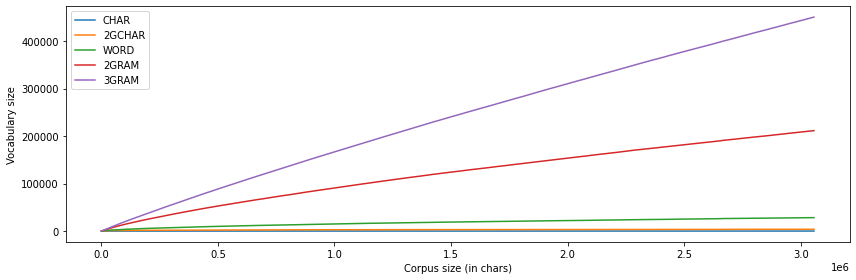

In [15]:
fig, ax = plt.subplots(figsize=(12, 4))
for label, idx in indexes.items():
    ax.plot(np.cumsum(idx.docs_size), idx.unique_words_history, label=label)
ax.set_xlabel('Corpus size (in chars)')
ax.set_ylabel('Vocabulary size')
plt.legend()
plt.tight_layout()
plt.show()

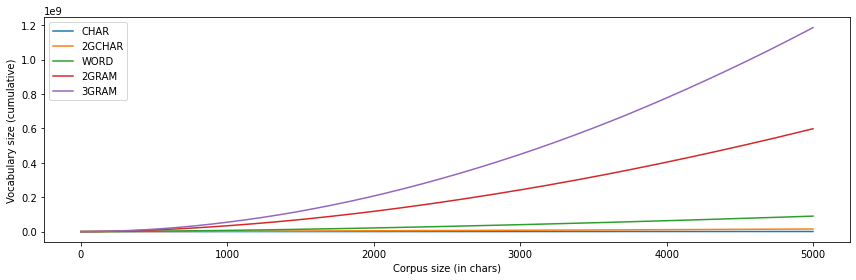

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
for label, idx in indexes.items():
    y = np.cumsum(idx.unique_words_history)
    ax.plot(y, label=label)
ax.set_xlabel('Corpus size (in chars)')
ax.set_ylabel('Vocabulary size (cumulative)')
plt.legend()
plt.tight_layout()
plt.show()

## PMI for bigrams

In [17]:
word_index = indexes['WORD']
bigram_index = indexes['2GRAM']
word_index.p('fish'), word_index.p('the'), bigram_index.p('the salad'), bigram_index.p('bleu salad')

(0.00027961570606055457,
 0.03558843657744196,
 5.137650101118295e-05,
 1.556863667005544e-06)

In [18]:
def pmi(bigram, th=10):
    a, b = bigram.split()
    count_a, count_b = sum(word_index.index[a].values()), sum(word_index.index[b].values())
    if count_a > th and count_b > th:
        return np.log(bigram_index.p(bigram) / (word_index.p(a) * word_index.p(b)))
    else:
        return 0

In [19]:
pmi('the salad'), pmi('bleu salad')

(1.0439384966781753, 0)

In [20]:
stats = []
for bigram in bigram_index.index.keys():
    stats.append({'bigram': bigram, 'pmi': pmi(bigram)})
S = pd.DataFrame(stats)

In [21]:
S.sort_values('pmi', ascending=False).head(20)

,bigram,pmi
52976,Whole Foods,10.535714
40655,Ice Cream,10.210292
47209,carne asada,10.180439
89016,Cheesecake Factory,10.076182
163710,shabu shabu,10.050206
49655,circus circus,9.978849
10484,Old Town,9.969130
48679,hash browns,9.954358
43762,Trader Joe,9.907105
49021,pan seared,9.781942


## Syntax-based tokenization

In [22]:
import sys
sys.path.append('/Users/flint/GitHub/lazy/lazy/openie/')

In [23]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [24]:
from spanzy import generate_graph, draw_graph
from openie_svo import triples, annotate_entities

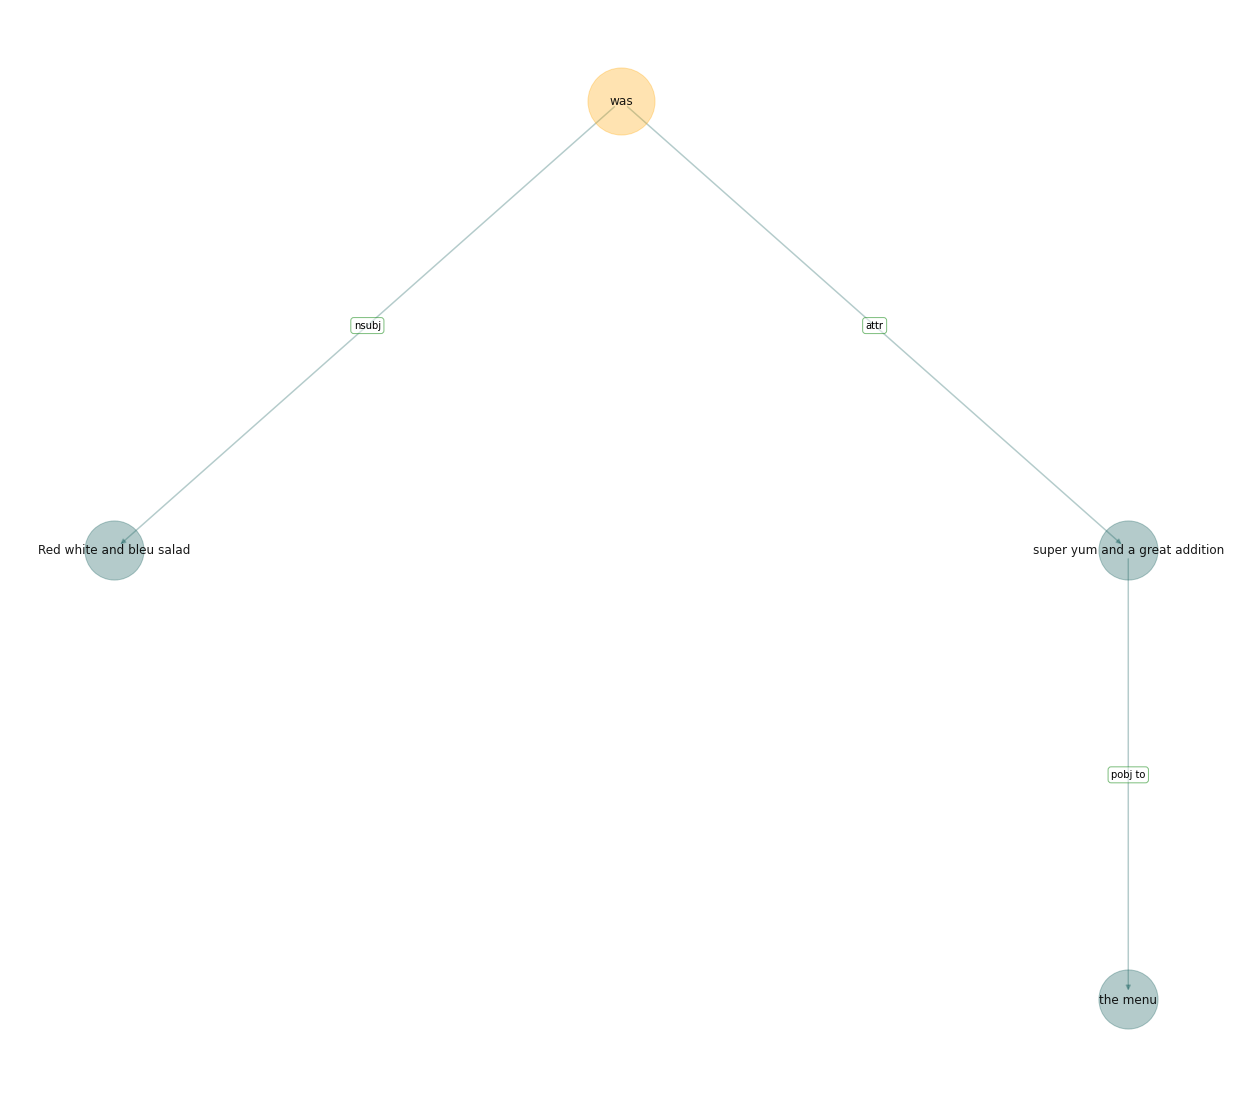

In [25]:
doc = nlp('Red, white and bleu salad was super yum and a great addition to the menu!')
G = generate_graph(doc, fold_preps=True)
fig = plt.figure(figsize=(22, 20))
draw_graph(G)

In [26]:
def syntax_tokenizer(document):
    G = generate_graph(nlp(document), fold_preps=True)
    return [a['node_text'] for _, a in G.nodes(data=True)]

In [27]:
tokenizers['SYNT'] = syntax_tokenizer
indexes['SYNT'] = InMemoryCountIndex(syntax_tokenizer)

In [28]:
for label, tokenizer in tokenizers.items():
    tokens = tokenizer(example)
    print(label, "\t=>({}/{})".format(len(set(tokens)), len(tokens)), "|".join(tokens[:10]), '...')

CHAR 	=>(33/322) R|e|d|,| |w|h|i|t|e ...
2GCHAR 	=>(153/321) Re|ed|d,|, | w|wh|hi|it|te|e  ...
WORD 	=>(53/72) Red|,|white|and|bleu|salad|was|super|yum|and ...
2GRAM 	=>(71/71) Red ,|, white|white and|and bleu|bleu salad|salad was|was super|super yum|yum and|and a ...
3GRAM 	=>(70/70) Red , white|, white and|white and bleu|and bleu salad|bleu salad was|salad was super|was super yum|super yum and|yum and a|and a great ...
SYNT 	=>(4/4) Red white and bleu salad|the menu|super yum and a great addition|was ...


In [29]:
for doc in tqdm(docs):
    indexes['SYNT'].add(doc)

  0%|          | 0/5000 [00:00<?, ?it/s]

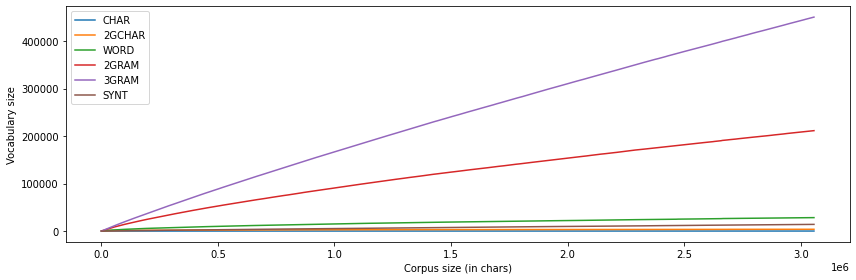

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
for label, idx in indexes.items():
    ax.plot(np.cumsum(idx.docs_size), idx.unique_words_history, label=label)
ax.set_xlabel('Corpus size (in chars)')
ax.set_ylabel('Vocabulary size')
plt.legend()
plt.tight_layout()
plt.show()

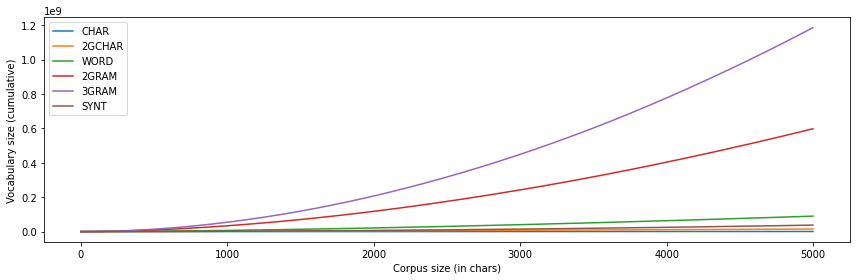

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))
for label, idx in indexes.items():
    y = np.cumsum(idx.unique_words_history)
    ax.plot(y, label=label)
ax.set_xlabel('Corpus size (in chars)')
ax.set_ylabel('Vocabulary size (cumulative)')
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
for word, documents in list(indexes['SYNT'].index.items())[:10]:
    print("{:40}{:20}{}".format(word, len(documents), list(documents.items())[:2]))

Red white and bleu salad                                   1[(0, 1)]
the menu                                                   7[(0, 1), (131, 1)]
super yum and a great addition                             1[(0, 1)]
was                                                      189[(0, 1), (27, 1)]
the momos                                                  1[(1, 1)]
the momo crawl                                             1[(1, 1)]
Ate                                                        1[(1, 1)]
Pizza                                                      6[(2, 1), (2841, 1)]
my night                                                   2[(2, 1), (3476, 1)]
here made                                                  1[(2, 1)]


In [37]:
for word, documents in list(indexes['WORD'].index.items())[:10]:
    print("{:20}{:20}{}".format(word, len(documents), list(documents.items())[:2]))

!                                   2498[(0, 4), (1, 2)]
and                                 4426[(0, 3), (1, 1)]
a                                   3839[(0, 3), (2, 1)]
great                               1324[(0, 3), (2, 2)]
the                                 4317[(0, 3), (1, 6)]
,                                   3728[(0, 2), (4, 3)]
was                                 2917[(0, 2), (1, 1)]
with                                2369[(0, 2), (2, 1)]
hit                                   91[(0, 2), (142, 1)]
of                                  3102[(0, 2), (1, 1)]


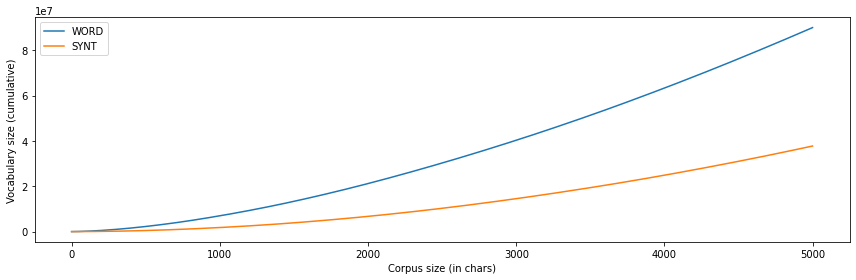

In [40]:
fig, ax = plt.subplots(figsize=(12, 4))
for label, idx in indexes.items():
    if label in ['WORD', 'SYNT']:
        y = np.cumsum(idx.unique_words_history)
        ax.plot(y, label=label)
ax.set_xlabel('Corpus size (in chars)')
ax.set_ylabel('Vocabulary size (cumulative)')
plt.legend()
plt.tight_layout()
plt.show()

# Normalizing text by lemmatization and POS selection

In [42]:
pos_filter = {'NOUN', 'VERB', 'ADJ', 'ADV'}

def filtered_lemma_tokenizer(document):
    doc = nlp(document)
    return [token.lemma_.lower() for token in doc if token.pos_ in pos_filter]

In [43]:
tokenizers['LEMMA'] = filtered_lemma_tokenizer
indexes['LEMMA'] = InMemoryCountIndex(filtered_lemma_tokenizer)

In [44]:
for label, tokenizer in tokenizers.items():
    tokens = tokenizer(example)
    print(label, "\t=>({}/{})".format(len(set(tokens)), len(tokens)), "|".join(tokens[:10]), '...')

CHAR 	=>(33/322) R|e|d|,| |w|h|i|t|e ...
2GCHAR 	=>(153/321) Re|ed|d,|, | w|wh|hi|it|te|e  ...
WORD 	=>(53/72) Red|,|white|and|bleu|salad|was|super|yum|and ...
2GRAM 	=>(71/71) Red ,|, white|white and|and bleu|bleu salad|salad was|was super|super yum|yum and|and a ...
3GRAM 	=>(70/70) Red , white|, white and|white and bleu|and bleu salad|bleu salad was|salad was super|was super yum|super yum and|yum and a|and a great ...
SYNT 	=>(4/4) Red white and bleu salad|the menu|super yum and a great addition|was ...
LEMMA 	=>(30/34) red|white|salad|super|yum|great|addition|menu|location|clean ...


In [45]:
for doc in tqdm(docs):
    indexes['LEMMA'].add(doc)

  0%|          | 0/5000 [00:00<?, ?it/s]

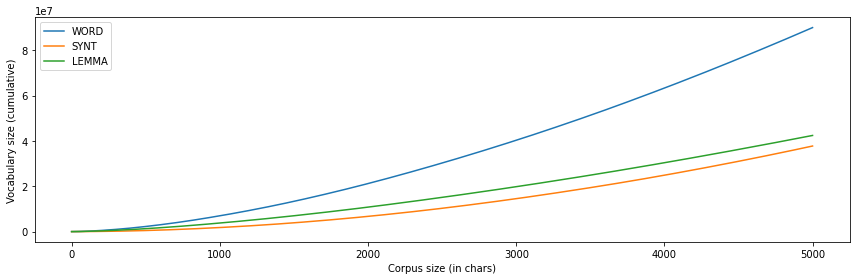

In [46]:
fig, ax = plt.subplots(figsize=(12, 4))
for label, idx in indexes.items():
    if label in ['WORD', 'SYNT', 'LEMMA']:
        y = np.cumsum(idx.unique_words_history)
        ax.plot(y, label=label)
ax.set_xlabel('Corpus size (in chars)')
ax.set_ylabel('Vocabulary size (cumulative)')
plt.legend()
plt.tight_layout()
plt.show()